In [1]:
import os
import operator
from dotenv import load_dotenv
from typing import Annotated, List
from typing_extensions import TypedDict, Literal

from pydantic import BaseModel, Field
from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display, Markdown
from langchain_tavily import TavilySearch

In [2]:
load_dotenv()

groq_api_key = os.getenv("GROQ_API_KEY")
tavily_api_key = os.getenv("TAVILY_API_KEY")

In [3]:
llm = init_chat_model("groq:llama-3.3-70b-versatile")

tavily_tool = TavilySearch(max_results=3)

In [4]:
class Section(BaseModel):
    name: str = Field(description="Name for this section of the report.")
    description: str = Field(description="A brief overview of the main topics and concepts to be covered in this section.")

class Sections(BaseModel):
    sections: List[Section] = Field(description="The sections of the report.")

class ReportState(TypedDict):
    topic: str
    sections: List[Section]
    research_data: Annotated[list, operator.add]
    completed_sections: Annotated[list, operator.add]
    final_report: str


In [5]:
def orchestrator(state: ReportState):
    """Orchestrator: Creates a plan (sections) for the report."""
    print("--- RUNNING ORCHESTRATOR ---")
    planner = llm.with_structured_output(Sections)
    report_sections = planner.invoke([
        SystemMessage(content="Create a detailed and comprehensive plan for a report."),
        HumanMessage(content=f"The report topic is: {state['topic']}"),
    ])
    return {"sections": report_sections.sections}


In [6]:
def researcher(state: ReportState):
    """Researcher: Conducts web searches for each planned section."""
    print("--- RUNNING RESEARCHER ---")
    research_results = []
    sections = state['sections']
    for section in sections:
        print(f"-> Researching section: {section.name}")
        query = f"in-depth information on: {state['topic']} - {section.name}: {section.description}"
        search_result = tavily_tool.invoke(query)
        research_results.append({
            "section_name": section.name,
            "research": search_result
        })
    return {"research_data": research_results}


In [7]:
def writer(state: ReportState):
    """Writer: Writes each section using the corresponding research data."""
    print("--- RUNNING WRITER ---")
    written_sections = []
    sections = state['sections']
    research_data = state['research_data']

    for section, research in zip(sections, research_data):
        print(f"-> Writing section: {section.name}")
        writer_prompt = f"""
        Write the following section in detail, using the provided research findings.
        Write only the section content, without a title and without any preamble. Use Markdown formatting.

        SECTION NAME: {section.name}
        SECTION DESCRIPTION: {section.description}

        RESEARCH FINDINGS TO USE:
        {research['research']}
        """
        section_content = llm.invoke([
            SystemMessage(content="You are an expert report writer."),
            HumanMessage(content=writer_prompt),
        ]).content
        full_section = f"## {section.name}\n\n{section_content}"
        written_sections.append(full_section)

    return {"completed_sections": written_sections}


In [8]:
def synthesizer(state: ReportState):
    """Synthesizer: Combines all completed sections into the final report."""
    print("--- RUNNING SYNTHESIZER ---")
    completed_sections = state["completed_sections"]
    final_report = "\n\n---\n\n".join(completed_sections)
    return {"final_report": final_report}


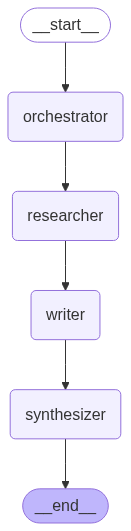

In [10]:
workflow = StateGraph(ReportState)

workflow.add_node("orchestrator", orchestrator)
workflow.add_node("researcher", researcher)
workflow.add_node("writer", writer)
workflow.add_node("synthesizer", synthesizer)


workflow.add_edge(START, "orchestrator")
workflow.add_edge("orchestrator", "researcher")
workflow.add_edge("researcher", "writer")
workflow.add_edge("writer", "synthesizer")
workflow.add_edge("synthesizer", END)

app = workflow.compile()

display(Image(app.get_graph().draw_mermaid_png()))

In [11]:
topic = "The career of LeBron James and his impact on the NBA"
initial_state = {"topic": topic, "research_data": [], "completed_sections": []}
final_state = app.invoke(initial_state)

Markdown(final_state["final_report"])

--- RUNNING ORCHESTRATOR ---
--- RUNNING RESEARCHER ---
-> Researching section: Introduction
-> Researching section: Early Life and High School Career
-> Researching section: Professional Career
-> Researching section: Awards and Accolades
-> Researching section: Impact on the NBA
-> Researching section: Conclusion
--- RUNNING WRITER ---
-> Writing section: Introduction
-> Writing section: Early Life and High School Career
-> Writing section: Professional Career
-> Writing section: Awards and Accolades
-> Writing section: Impact on the NBA
-> Writing section: Conclusion
--- RUNNING SYNTHESIZER ---


## Introduction

### Early Life and Career
LeBron James, born on December 30, 1984, in Akron, Ohio, is an American professional basketball player widely regarded as one of the greatest all-around players of all time. His impressive career spans over two decades, with numerous accolades and achievements that have cemented his position as a legend in the National Basketball Association (NBA).

### NBA Championships and Accolades
James has won NBA championships with the Miami Heat (2012 and 2013), the Cleveland Cavaliers (2016), and the Los Angeles Lakers (2020), demonstrating his ability to perform under pressure and lead his teams to victory. In the 2011-2012 season, he averaged 27.1 points per game and won his third MVP award, helping Miami advance to its second consecutive NBA finals appearance. His exceptional skills on the court have earned him numerous awards and recognition, including being named Ohio Mr. Basketball and selected to the _USA Today_ All-USA First Team.

### Impact on the NBA
James' impact on the NBA extends beyond his impressive statistics and championship wins. He has been a trailblazer for players, using his platform to speak out on social issues and challenge the status quo. His decision to leave Cleveland and join the Miami Heat in 2010 sparked a national debate, with some criticizing his move as "cowardly" and "selfish." However, James has consistently demonstrated his commitment to his craft and his community, using his influence to bring attention to important issues and inspire a new generation of players and fans.

### Records and Achievements
Throughout his career, James has set numerous records and achieved impressive milestones. He became the first player in NBA history to average a triple-double in the Finals, with a statistical line of 33.6 points, 12 rebounds, and 10 assists across the series. His ability to dominate the game and lead his team to victory has earned him a reputation as one of the greatest players of all time, with many comparing him to legends like Magic Johnson and Michael Jordan.

---

## Early Life and High School Career

### Family Background and Early Life
LeBron James was born on December 30, 1984, in Akron, Ohio, to Gloria James, a single mother. His father, Anthony McClelland, was not actively involved in his life. Despite the challenges they faced, Gloria worked tirelessly to provide for LeBron and his family. The James family struggled financially, and they often had to move from one apartment to another. However, Gloria's dedication and support played a significant role in shaping LeBron's early life and career.

### Introduction to Basketball
LeBron's introduction to basketball came at a young age. He started playing organized basketball at the age of five and quickly fell in love with the game. He joined a local youth basketball league, where he developed his skills and learned the fundamentals of the game. As he grew older, LeBron's passion for basketball only intensified, and he began to dream of playing in the NBA.

### High School Career
LeBron attended St. Vincent-St. Mary High School in Akron, where he quickly became a dominant force on the basketball court. He led the team to three state championships and was named Ohio's Mr. Basketball three times. During his senior year, LeBron averaged 31.6 points, 9.6 rebounds, and 4.6 assists per game, earning him numerous awards and accolades, including the Naismith Trophy, the McDonald's All-American Game MVP, and the USA Today Player of the Year award.

### Factors Contributing to Success
Several factors contributed to LeBron's success during his early life and high school career. His mother's unwavering support and dedication played a significant role in his development as a basketball player. Additionally, LeBron's natural talent, combined with his strong work ethic and determination, helped him to excel on the court. His experience playing in local youth basketball leagues and his participation in national basketball tournaments also helped him to gain exposure and develop his skills.

### National Recognition
LeBron's impressive performance in high school earned him national recognition. He was featured on the cover of *Sports Illustrated* at the age of 17, becoming one of the youngest players to ever appear on the cover. He also appeared in numerous other publications, including *ESPN The Magazine* and *SLAM Magazine*. The national attention and accolades LeBron received during his high school career helped to pave the way for his future success in the NBA.

---

## Professional Career

### Introduction to Professional Career
LeBron James is widely regarded as one of the greatest all-around players in the history of the National Basketball Association (NBA). Born on December 30, 1984, in Akron, Ohio, James has had a storied professional career, playing for the Cleveland Cavaliers, Miami Heat, and Los Angeles Lakers.

### Cleveland Cavaliers (2003-2010, 2014-2018)
James was drafted first overall by the Cleveland Cavaliers in 2003 and quickly established himself as a dominant force in the league. During his first stint with the Cavaliers, James averaged 27.8 points, 7.0 rebounds, and 7.0 assists per game, earning him numerous accolades, including four NBA Most Valuable Player (MVP) awards. In 2016, James led the Cavaliers to their first NBA championship, defeating the Golden State Warriors in the NBA Finals.

### Miami Heat (2010-2014)
In 2010, James joined the Miami Heat, where he won two consecutive NBA championships (2012 and 2013) alongside Dwyane Wade and Chris Bosh. During his time with the Heat, James averaged 26.9 points, 7.7 rebounds, and 6.7 assists per game, solidifying his position as one of the league's top players.

### Los Angeles Lakers (2018-present)
In 2018, James signed with the Los Angeles Lakers, where he has continued to excel, leading the team to an NBA championship in 2020. James has averaged 25.7 points, 7.9 rebounds, and 7.2 assists per game with the Lakers, further cementing his legacy as one of the greatest players in NBA history.

### Notable Achievements and Records
Throughout his career, James has achieved numerous notable records and milestones, including:
* Four NBA Most Valuable Player (MVP) awards
* Four NBA championships (2012, 2013, 2016, and 2020)
* Four NBA Finals MVP awards
* 17 NBA All-Star Game selections
* Two Olympic gold medals
* Youngest player to reach 35,000 career points

### Impact on the NBA
James' impact on the NBA extends beyond his on-court accomplishments. He has been an influential figure in the league, using his platform to speak out on social justice issues and advocate for players' rights. James' decision to leave Cleveland for Miami in 2010 sparked a national debate about player movement and loyalty, and his subsequent return to Cleveland in 2014 was seen as a testament to his commitment to his hometown. Today, James remains one of the most dominant players in the league, continuing to inspire and influence a new generation of players and fans.

---

## Awards and Accolades

### Awards and Accolades
LeBron James has accumulated numerous awards and accolades throughout his illustrious career, solidifying his position as one of the greatest players in NBA history. His impressive list of achievements includes:
* **Four NBA Championships**: James won two championships with the Miami Heat (2012 and 2013), one with the Cleveland Cavaliers (2016), and one with the Los Angeles Lakers (2020).
* **Four NBA Finals MVPs**: He was named the NBA Finals MVP in 2012, 2013, 2016, and 2020, demonstrating his exceptional performance in the championship series.
* **Four Regular-Season MVPs**: James has been awarded the regular-season MVP title four times, recognizing his outstanding overall performance during the season.
* **20 All-Star Appearances**: He has been selected to the NBA All-Star Game 20 times, showcasing his consistent excellence and dominance in the league.
* **20 All-NBA Selections**: James has been named to the All-NBA Team 20 times, highlighting his status as one of the best players in the league.
* **Six All-Defensive Awards**: He has received six All-Defensive awards, demonstrating his exceptional defensive skills and ability to guard multiple positions.
* **Three Olympic Gold Medals**: James has won three Olympic gold medals, showcasing his ability to perform at the highest level on the international stage.
* **2024 Olympic MVP**: He was named the MVP of the 2024 Olympics, further solidifying his reputation as one of the greatest players of all time.
* **Inaugural NBA Cup MVP**: James was awarded the inaugural NBA Cup MVP, recognizing his outstanding performance in the tournament.
* **Three All-Star MVPs**: He has been named the NBA All-Star Game MVP three times, demonstrating his ability to excel in showcase events.
With career averages of 27.1 points, 7.5 rebounds, and 7.4 assists per game, James has established himself as an all-time great, with his numerous awards and accolades serving as a testament to his hard work, dedication, and unwavering commitment to excellence.

---

## Impact on the NBA

### Influence on the Game
LeBron James is widely regarded as one of the greatest basketball players in NBA history, with a career spanning over two decades. His impact on the game is multifaceted, with his impressive statistics and accolades being a testament to his incredible skill and dedication. As a four-time NBA champion, four-time finals MVP, and four-time NBA MVP, LeBron has consistently demonstrated his ability to perform at an elite level, inspiring a new generation of players with his work ethic and passion for the game.

### Shaping the League's Culture
LeBron's influence extends beyond his on-court accomplishments, as he has played a significant role in shaping the league's culture. His decision to leave Cleveland and join the Miami Heat in 2010, for example, marked a significant shift in the way players approached free agency and team building. This move sparked a national debate, with some criticizing LeBron for his perceived disloyalty to his hometown team. However, LeBron's actions also highlighted the complexities of player movement and the business side of the NBA, sparking important conversations about player empowerment and the role of superstars in shaping the league.

### Legacy and Impact on the NBA
LeBron's legacy continues to grow, with his on-court achievements and off-court activism cementing his status as one of the most influential figures in the NBA. His commitment to social justice and community development has inspired a new generation of players to use their platforms for positive change. Furthermore, LeBron's entrepreneurial ventures, including his production company and philanthropic efforts, have demonstrated his dedication to creating opportunities for underrepresented groups and promoting education and economic empowerment. As a result, LeBron's impact on the NBA extends far beyond his playing career, with his influence likely to be felt for generations to come.

### Statistical Achievements and Records
LeBron's impressive statistical achievements are a testament to his enduring impact on the game. His record as the first player in NBA history to average a triple-double in the Finals, with a statistical line of 33.6 points, 12 rebounds, and 10 assists across the series, is a remarkable achievement that highlights his incredible versatility and dominance on the court. Additionally, his four NBA championships, four MVP awards, and numerous other accolades demonstrate his consistent excellence and dedication to the sport.

### Conclusion
In conclusion, LeBron James' impact on the NBA is profound and far-reaching, with his influence extending beyond his on-court accomplishments to shape the league's culture, inspire a new generation of players, and promote positive change through his social justice and community development efforts. As one of the greatest basketball players in NBA history, LeBron's legacy will continue to grow, with his impact on the game and the league likely to be felt for generations to come.

---

## Conclusion

### Summary of LeBron James' Career
LeBron James is widely regarded as one of the greatest all-around players in the history of the National Basketball Association (NBA). Born on December 30, 1984, in Akron, Ohio, James has had a storied career spanning over two decades. He has won numerous accolades, including four NBA championships with the Miami Heat, Cleveland Cavaliers, and Los Angeles Lakers.

### Lasting Impact on the NBA
Throughout his career, James has consistently demonstrated his exceptional skills on the court, earning him multiple Most Valuable Player (MVP) awards. In the 2011-2012 season, he averaged 27.1 points per game and led the Miami Heat to their second consecutive NBA finals appearance. James' impressive performance in the playoffs, including scoring over 40 points seven times in 18 Eastern Conference postseason games, solidified his position as one of the greatest players of all time.

### Legacy and Achievements
James' achievements extend beyond his on-court performance. He has been named Ohio Mr. Basketball and selected to the _USA Today_ All-USA First Team. He also became the first junior to be named male basketball Gatorade National Player of the Year. James' high school career was marked by notable accomplishments, including appearing on the cover of _Sports Illustrated_ and being named to the _USA Today_ All-USA First Team.

### Enduring Influence
LeBron James' lasting impact on the NBA is undeniable. His impressive career statistics, numerous awards, and consistent dominance on the court have cemented his status as one of the greatest players in NBA history. As he continues to play and inspire new generations of basketball fans, James' legacy will undoubtedly endure for years to come. His influence extends beyond the court, with his philanthropic efforts and commitment to social justice initiatives making a lasting impact on the world of sports and beyond.